In [1]:
import sys

In [2]:
sys.path.insert(0,'../../optimization/rtms_bayesopt/lib/python2.7/site-packages/')
sys.path.insert(0,'/KIMEL/tigrlab/projects/jjeyachandra/gmsh-sdk/lib/')

In [3]:
import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import gmsh

%matplotlib notebook

In [4]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """
    if isinstance(vector, np.ndarray):
        return np.array([[0, -vector.item(2), vector.item(1)],
                         [vector.item(2), 0, -vector.item(0)],
                         [-vector.item(1), vector.item(0), 0]])
    else:
        return np.array([[0, -vector[2], vector[1]], 
                         [vector[2], 0, -vector[0]], 
                         [-vector[1], vector[0], 0]])

In [5]:
psurf_file = '../../output/param_surf.msh'

## Finding an Analytical Approximation of the Spatial Sampling Surface

In [31]:
#Load via gmsh
gmsh.initialize()
gmsh.open(psurf_file)

In [32]:
#Get set of nodes that correspond to the surface patch we want to fit
entity = gmsh.model.getEntities()[0]
nodes, coords, params = gmsh.model.mesh.getNodes(entity[0],entity[1])
coords = np.array(coords).reshape((len(coords)//3,3))

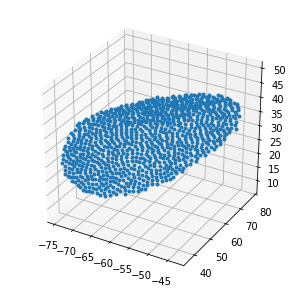

In [33]:
#Plot mesh 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot3D(coords[:,0],coords[:,1],coords[:,2],'.')
plt.show()

In [9]:
#Load in the normal vertex and get z unit vector
v_norm = np.fromfile('../../output/norm_varr')
v_norm = v_norm/np.linalg.norm(v_norm)
z = np.array([0,0,1],dtype=np.float64)

In [10]:
#Calculate rotation (figure this out...)
v = np.cross(v_norm,z)
sin = np.linalg.norm(v)
cos = np.dot(v_norm,z)
R = np.eye(3) + skew(v) + np.matmul(skew(v),skew(v))*( 1 - cos )/(sin**2)

In [11]:
#Apply rotational matrix to align normal with Z axis
r_coords = np.matmul(R,coords.T).T

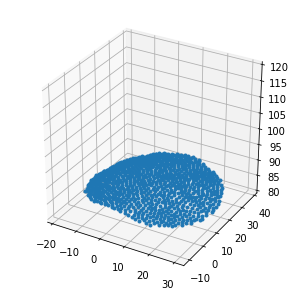

In [12]:
#Plot mesh 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection='3d')
ax.plot3D(r_coords[:,0],r_coords[:,1],r_coords[:,2],'.')
ax.set_zlim(bottom=80,top=120)
plt.show()

### Method 1: Quadratic Surface Fitting
Fit a function defined by:

$$f(x,y)= ax + by + cxy + dx^2 + ey^2$$

Define a transformation that takes the function mapping $f(x,y)$ and performs a rotation into the original mesh space

In [13]:
from scipy.linalg import lstsq

In [14]:
#Column stack 1 (x,y) (x*y) (x^2 y^2)
#Formulate as Ax = b
A = np.c_[ 
        
    np.ones(r_coords.shape[0]), #bias
    r_coords[:,:2],             #x,y
    np.prod(r_coords[:,:2],axis=1),  #xy
    r_coords[:,:2]**2 # x^2,y^2
]

b = r_coords[:,2]

#Solve yielding (a,b,c,d,e) scalars
C,_,_,_ = lstsq(A,b)

In [15]:
minarr = np.min(r_coords,axis=0)
maxarr = np.max(r_coords,axis=0)

In [16]:
#Define grid for visualization
X,Y = np.meshgrid(np.linspace(minarr[0]+1,maxarr[0]-1), np.linspace(minarr[1]+1,maxarr[1]-1))
XX = X.flatten()
YY = Y.flatten()

In [17]:
#Compute polynomial 
poly_arr = np.c_[ np.ones(XX.shape[0]), XX, YY, XX*YY, XX*XX, YY*YY]
Z = np.dot(poly_arr,C)

In [18]:
Z.reshape(X.shape).shape

(50, 50)

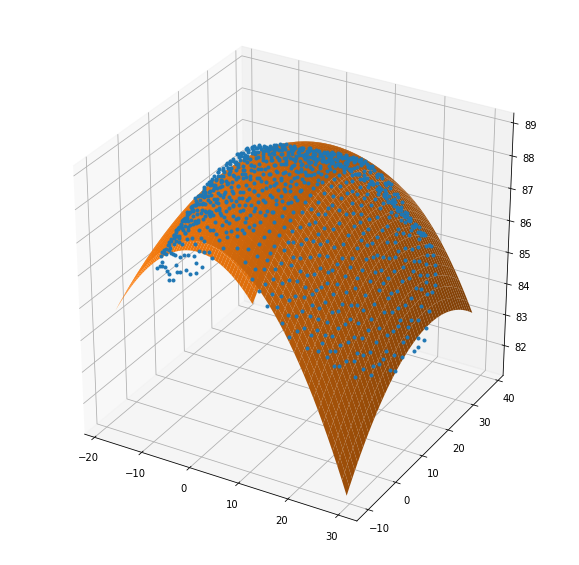

In [19]:
#Visualize
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.plot3D(r_coords[:,0],r_coords[:,1],r_coords[:,2],'.')
ax.plot_surface(X,Y,Z.reshape(X.shape),alpha=1,lw=0.5)
plt.show()

#### Convert into a GMSH surface

In [20]:
#Invert the rotation
inv_R = np.linalg.pinv(R)

In [21]:
#Transform back into mesh space
poly_coords = np.matmul(inv_R, np.c_[XX,YY,Z].T).T

In [22]:
poly_coords.shape

(2500, 3)

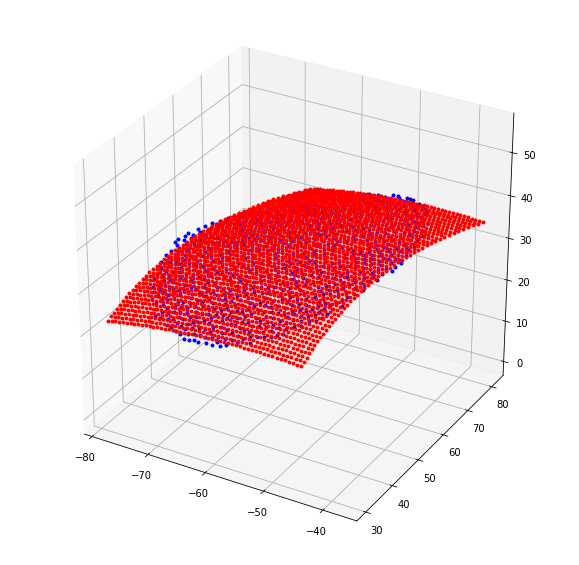

In [23]:
#Plot in original mesh space
#Plot mesh 
fig = plt.figure(figsize=(10,10,))
ax = fig.add_subplot(111,projection='3d')
ax.plot3D(coords[:,0],coords[:,1],coords[:,2],'b.')
ax.plot3D(poly_coords[:,0],poly_coords[:,1],poly_coords[:,2],'r.')
plt.show()

## 

## Export of parameterized surface

In [24]:
#Make TINGS and draw quadilaterals for visualization
samp_surf_coords = poly_coords.flatten(order='C')
samp_surf_nodes = np.arange(max(nodes),max(nodes)+poly_coords.shape[0])

In [25]:
grid = samp_surf_nodes.reshape((50,50))

In [26]:
n = grid.shape[0]

In [27]:
trig_list = np.zeros( (6 * (n-1)**2 ), dtype=np.int64 )
for j in np.arange(0,grid.shape[0] - 1):
    for i in np.arange(0,grid.shape[1] - 1):
        
        
        #Upper triangular
        trig_list[ 6*i   + 6*(n-1)*j ] = grid[(j,i)]
        trig_list[ 6*i+1 + 6*(n-1)*j ] = grid[(j,i+1)]
        trig_list[ 6*i+2 + 6*(n-1)*j ] = grid[(j+1,i+1)]
        
        #Lower triangular
        trig_list[ 6*i+3 + 6*(n-1)*j ] = grid[(j+1,i)]
        trig_list[ 6*i+4 + 6*(n-1)*j ] = grid[(j,i)]
        trig_list[ 6*i+5 + 6*(n-1)*j ] = grid[(j+1,i+1)]    

In [28]:
import gmsh

In [29]:
#Save the parameterized surface as a mesh model for visualization
gmsh.initialize()
gmsh.model.add('samp_surf')
tag = gmsh.model.addDiscreteEntity(2,3002)
gmsh.model.mesh.setNodes(2,tag,nodeTags=samp_surf_nodes,coord=samp_surf_coords)
gmsh.model.mesh.setElements(2,tag, [2], 
                           elementTags=[range(1,len(trig_list)//3 + 1)],
                           nodeTags=[trig_list])
gmsh.write('../../output/samp_surf.msh')
gmsh.finalize()

In [30]:
#Export the quadratic surface vector for later use in optimization
C.tofile('../../output/quadratic_vec')